---
![Pictured: Land Development in Maricopa County](develop.jpg){width=50%}

#code to add a picture where the format is the following:
#[caption of photo](photo.png)[width=x%]

---

# Biodiversity Intactness Index Change in Phoenix from 2017 to 2020


Using the Microsoft Planetary Computer, 2017 and 2020 rasters of Phoenix subdivision were employed to study biodiversity loss in Maricopa County. In 2021, Maricopa County was the US county that added the most developed land since 2001. Several species of animals have already been greatly impacted, including the Sonoran Pronghorn, Desert Tortoise, Cactus Ferruginous Pygmy-Owl, Sonora Tiger Salamander, and Border Cats such as Ocelots, Cougars, etc. Along with land development, some other factors contributing to biodiversity loss include mining, population increase, urbanization, recreation, high per capita water consumption, water diversion, and animal agriculture. In order to study this, the biodiversity intactness index (BII) will be used to find changes in BII from 2017 to 2020. 

Author: Kate Becker

Published: Dec 10, 2023

## Contents
-  Import relevant libraries, functions, and the microsoft computer 
-  Data access
-  Catalog search and selection for io-biodiversity collection 
-  Metadata exploration
-  Metadata and raster access and axploration for the 2017 and 2020 STAC Items
-  Phoenix subdivision biodiversity index analysis
-  Data wrangling for spatial datasets
- 

## Import Relevant Libraries, Functions, and the Microsoft Planetary Computer

In order to perform this analysis, several libraries and functions must be imported in order to work with geospatial data, particularly for accessing, processing, and visualizing raster and vector data. The Microsoft Planetary Computer must also be imported in order to access the STAC catalog and obtain the io-biodiversity collection. 

In [24]:

import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import contextily as ctx
import rasterio
from rasterio.plot import show as rioshow
from shapely.geometry import box
import xarray as xr

from shapely.geometry import Polygon

# used to access STAC catalogs
from pystac_client import Client
# used to sign items from the MPC STAC catalog
import planetary_computer

# ----- other libraries for nice ouputs
from IPython.display import Image


## Data Access

1. **BII data**: This dataset is part of the MPC STAC catalog. Within the MPC STAC catalog, access the ‘io-biodiversity’ collection and access the 2017 and 2020 rasters covering Phoenix subdivision. The following coordinates were employed to specify a bounding box: 
[-112.826843, 32.974108, -111.184387, 33.863574]

2. **Phoenix subdivision**: Within the Census County Subdivision shapefiles access the Phoenix subdivision polygon in the  Arizona: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions

### Arizona Shapefile Read in and a View of Phoenix County

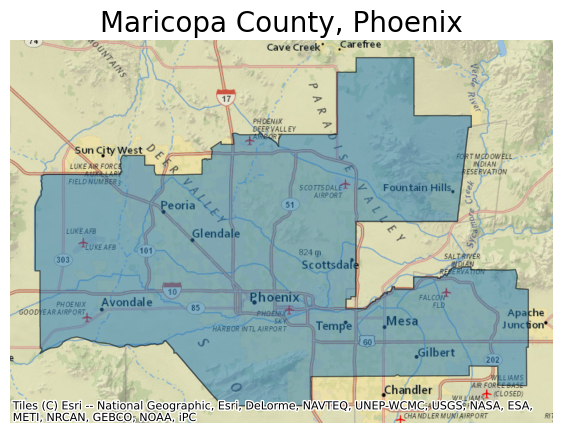

In [25]:
arizona = gpd.read_file('data/tl_2022_04_cousub/tl_2022_04_cousub.shp')
arizona.head()
phoenix = arizona[arizona['NAME'] == "Phoenix"]

# create axis with plot
ax = (phoenix.to_crs(epsg=3857)
      .plot(figsize=(7, 7), alpha=0.5, edgecolor="k")
      )

# add NatGeo basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)

# update axes
ax.set_title("Maricopa County, Phoenix", fontdict={"fontsize": "20"})
ax.set_axis_off()

## Catalog Access and Search for the Io-Biodiversity Collection
Using the Microsoft Planetary Computer, the io-biodiversity collection will be accessed along with its metadata and assets in order to perform this analysis. The metadata for a STAC item includes core identifying information (such as id, geometry, bounding box, and date), and additional properties (for example, place of collection). In comparison, assets are links to the actual data of the item (for example, links to the spectral bands of a satellite image.) These identifiers are useful when trying to perform a more detailed catalog search. 

In [26]:
## Catalog search 
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                      modifier = planetary_computer.sign_inplace)
#temporal range of interest
time_range = '2017/2020'
#Bounding Box Coordinates (as a GeoJSON)
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]
#Catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_range
)
items = search.item_collection()
items
#Number of items in the search:
len(items)

items #tells us there were two items in the catalog that matched our search

## Metadata and Raster Access and Exploration for the 2017 and 2020 STAC Items

In [27]:
#get fourth item in the catalog search
ph_2017 = items[3]
# get first item in the catalog search
ph_2020 = items[0]

# print item id and properties for 2017 and 2020 
ph_2017
ph_2020

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>

The raster data in our current items is within the "data" asset and can be accessed via its URL. We will open the raster directly using ``rioxr.open_rasterio()``

In [28]:
ph_2017 = rioxr.open_rasterio(ph_2017.assets['data'].href)
ph_2020 = rioxr.open_rasterio(ph_2020.assets['data'].href)

### 2017 and 2020 Raster Covering Phoenix Subdivision Preview

#### 2017 Raster 

In [29]:
Image(url=ph_2017.assets['rendered_preview'].href, width=500)

AttributeError: 'DataArray' object has no attribute 'assets'

#### 2020 Raster

In [ ]:
Image(url=ph_2020.assets['rendered_preview'].href, width=500)

## Phoenix Subdivision Biodiversity Index Analysis

In order to study biodiversity loss, the biodiversity intactness index (BII)is employed which estimates how the average abundance of native terrestrial species in a region (2020) compares with their abundances before pronounced human impacts (2017). Area that has been lost with a BII of at least 0.75 or greater signifies an extreme biodiversity loss and is therefore used as a threshold in this analysis. 

In [30]:
#set threshold
bi_threshold >= 0.75

#found the areas in which the BII was greater than 0.75
above_thresh_2017 = ph_2017 >= bi_threshold 
above_thresh_2020 = ph_2020 >= bi_threshold 

#casted it as int. data array to accecss binary values 
above_thresh_2017 = above_thresh_2017.astype(int) 
above_thresh_2020 = above_thresh_2020.astype(int) 

#calculating the the total number of pixels in the phoenix subdivision for 2017 and 2020 
total_2017 = np.sum(ph_2017) 
total_2020 = np.sum(ph_2020) 

#calculating the percentage of pixels with a BII of at least 0.75
percent_2017 = (np.sum(above_thresh_2017 / total_2017)) * 100  
percent_2020 = (np.sum(above_thresh_2020 / total_2020)) * 100

#check: look at new variable 
#percent_2017
#percent_2020

#identify the lost pixels 
lost_pixels = above_thresh_2017 - above_thresh_2020 
print(np.sum(lost_pixels))

#print percentage values for 2017 and 2020 
print(f"Percentage of area with BII >= 0.75 in 2017: {percent_2017:.2f}%")
print(f"Percentage of area with BII >= 0.75 in 2020 {percent_2020:.2f}%")

## Data Wrangling for Spatial Datasets

In order to perform geospatial operations, it's crucial to ensure that two spatial datasets (a GeoDataFrame and a raster dataset) are aligned in terms of their coordinate reference systems (CRS) and spatial extent. This alignment is necessary for accurate spatial analysis and overlays between vector and raster data.

In [ ]:
#make crs' the same 
phoenix = phoenix.to_crs(lost_pixels.rio.crs)

#check to make sure crs' match
phoenix.crs == lost_pixels.rio.crs

#clipping the bii data to phoenix geometry 
lost_pixels = lost_pixels.rio.clip(phoenix.geometry, phoenix.crs) 

#clipping the ph_2020 data to phoenix geometry 
ph_2020 = ph_2020.rio.clip(phoenix.geometry, phoenix.crs)

#check
#type(lost_pixels)
#type(phoenix)
#type(above_thresh_2017)

NameError: name 'lost_pixels' is not defined

### Preparing and Cleaning Raster Data

For further analysis this step is necessary in order to effectively process raster data. This is done to clean up unnecessary information in the dataset, especially if you're not performing analyses based on bands. It also simplifies the structure of the data, especially if you're working with a single-band raster. This kind of data preprocessing is common in geospatial analysis workflows to ensure data consistency and relevance to the study area.

In [ ]:
# original dimensions and coordinates
print(ph_2020.dims, ph_2020.coords,'\n')

# remove length 1 dimension (band)
ph_2020 = ph_2020.squeeze()
print(ph_2020.dims, ph_2020.coords,'\n')

# remove coordinates associated to band
ph_2020 = ph_2020.drop('band')
print(ph_2020.dims, ph_2020.coords)

#clipping the ph_2020 data to phoenix geometry 
ph_2020 = ph_2020.rio.clip(phoenix.geometry, phoenix.crs)

#check: plot the area showing BII > 0.75 
lost_pixels.plot() # plot this and plot phoenix shapefile 

('band', 'y', 'x') Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29 33.29
    spatial_ref  int64 0 

('y', 'x') Coordinates:
    band         int64 1
  * x            (x) float64 -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29 33.29
    spatial_ref  int64 0 

('y', 'x') Coordinates:
  * x            (x) float64 -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29 33.29
    spatial_ref  int64 0


## Visualization showing the area with BII >= 0.75 in 2017 that was lost by 2020
In order to effectively complete this analysis and create a meaningful and insightful map, all of the relevant data must be compiled together. 

AttributeError: 'NoneType' object has no attribute 'remove'

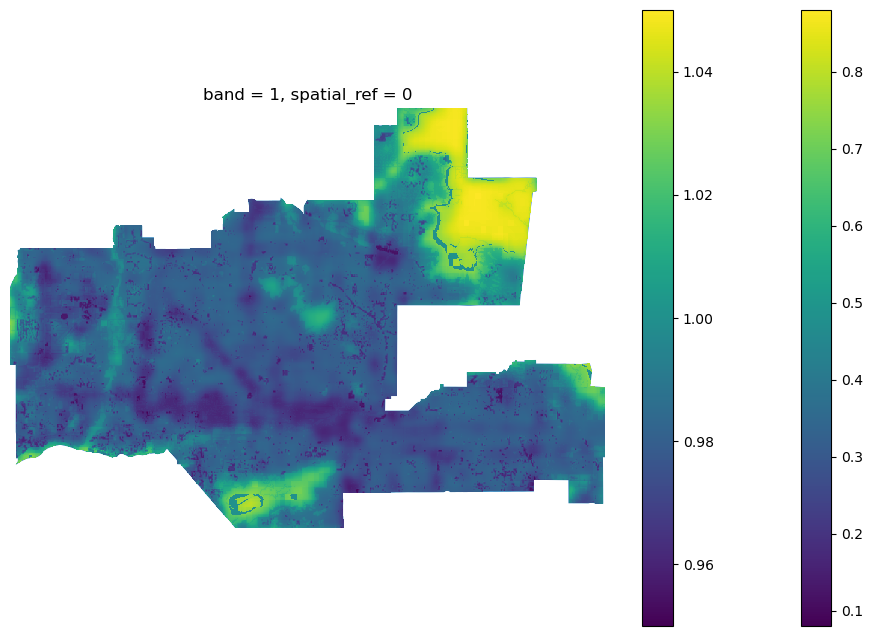

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('off')

phoenix.plot(ax=ax) #plot phoenix shapefile 
ph_2020.plot(ax=ax, add_colorbar=False) #plot 2020 raster
lost_pixels.where(lost_pixels == 1).plot(ax=ax, color  = 'pink') #plotting the area with BII >= 0.75 in 2017 that was lost by 2020

plt.title('Maricopa County with Areas of Extreme Biodiversity Loss') #added a title 

plt.show() #printed map 

#get rid of bar on left 

### Findings
Now that the data processing is over we can plot the phoenix shapefile, the 2020 raster, and the raster containing the biodiversity loss from 2017 to 2020. It appears that there was a signficant loss in biodiversity within Maricopa County as a result of land development. The areas with a neon yellow hue are those with BII>=0.75 in 2017 that were lost by 2020. Over a three year period, this loss is catastrophic for such a small termporal scale. This analysis can be further explored to measure biodiversity levels as climate change and human encorachment continues. 

### Sources
Microsoft. (Year). Microsoft Planetary Computer. https://planetarycomputer.microsoft.com/


U.S. Census Bureau. (2022). TIGER/Line Shapefiles: 2022 County Subdivisions. U.S. Census Bureau. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions
